In [7]:
import random
from pprint import pprint

from matplotlib import pyplot as plt
from process_bigraph import Composite, ProcessTypes
from process_bigraph.emitter import emitter_from_wires, gather_emitter_results

from cdFBA import register_types
from cdFBA.utils import get_substrates, make_cdfba_composite

from spatial_transport.processes.diffusion import get_simple_diffusion_spec
from spatial_transport.processes.advection import get_simple_advection_spec
from spatial_transport import register_types as register_types2
from spatial_transport.utils import generate_voxels, generate_shared_environment, get_regular_edges, run_test

ImportError: cannot import name 'run_test' from 'spatial_transport.utils' (/Users/tasnifrahman/PycharmProjects/spatial_transport/spatial_transport/utils.py)

In [9]:
# # #Load E. coli model
# E_no_galE = cobra.io.load_model("iAF1260")
# # #Copy model
# E_no_LCTStex = E_no_galE.copy()
# # #Knock out galactose metabolism
# E_no_galE.genes.b0759.knock_out() # cannot metabolize galactose
# # #Knock out Lactose transport reaction LCTStex
# E_no_LCTStex.reactions.LCTStex.knock_out() # cannot uptake lactose
#
# #save models in SBML format
# write_sbml_model(E_no_galE, "E_no_galE.xml")
# write_sbml_model(E_no_LCTStex, "E_no_LCTStex.xml")

In [2]:
exchanges = ['EX_lcts_e', 'EX_gal_e']
all_species = ['EX_lcts_e', 'EX_gal_e', 'deltaGal', 'deltaLac']
substrates = get_substrates(model_file="iAF1260", exchanges=exchanges)

In [3]:
model_dict = {
    'deltaGal':'E_no_galE.xml',
    'deltaLac':'E_no_LCTStex.xml'
}

In [4]:
voxels = generate_voxels([15,1,0], spacing=1)
edges = get_regular_edges(voxels, periodic=False, spacing=1)

In [5]:
def generate_simple_cdfba_composite(voxels, model_dict, exchanges, volume):
    substrates = []
    species_list = [species for species in model_dict.keys()]
    for species, model in model_dict.items():
        substrates += get_substrates(model_file=model, exchanges=exchanges)
    base_spec = make_cdfba_composite(model_dict=model_dict, exchanges=exchanges, volume=volume, interval=0.1)
    for id in voxels:
        spec = base_spec.copy()
        shared_environment = generate_shared_environment(volume=1, substrates=substrates, species=species_list)
        spec["Shared Environment"] = shared_environment
        voxels[id].update(spec)
    return voxels

In [6]:
compartments = generate_simple_cdfba_composite(voxels, model_dict, exchanges, 1, sub_range=(5,5), bio_range=(0.05,0.05))

TypeError: generate_simple_cdfba_composite() got an unexpected keyword argument 'sub_range'

In [23]:
spec = {"Compartments": compartments, "Edges": edges}

In [24]:
for species in model_dict.keys():
    substrates.append(species)

In [25]:
substrates_dict = {
    "Lactose C12H22O11": 0.03,
    "D-Galactose": 0.06,
    "deltaGal": 0.001,
    "deltaLac": 0.001
}

In [26]:
spec["Simple Diffusion"] = get_simple_diffusion_spec(substrates=substrates_dict, interval = 0.1)

In [27]:
spec["Simple Advection"] = get_simple_advection_spec(spacing=1, substrates=substrates, advection=[0, 0.5, 0], boundary="default", interval=0.1)

In [28]:
spec["emitter"] = emitter_from_wires({
        "global_time": ["global_time"],
        'compartments': ["Compartments"],
    })

In [29]:
core = ProcessTypes()
core = register_types(core)
core = register_types2(core)

In [30]:
sim = Composite(
        {
            "state": spec,
        },
        core=core
    )

In [31]:
sim.run(20)
results = gather_emitter_results(sim)[("emitter",)]

In [45]:
x_positions = [results[0]["compartments"][compartment]["position"][0] for compartment in results[0]["compartments"].keys()]
lactose_conc = [results[20]["compartments"][compartment]["Shared Environment"]["concentrations"]["Lactose C12H22O11"] for compartment in results[0]["compartments"].keys()]

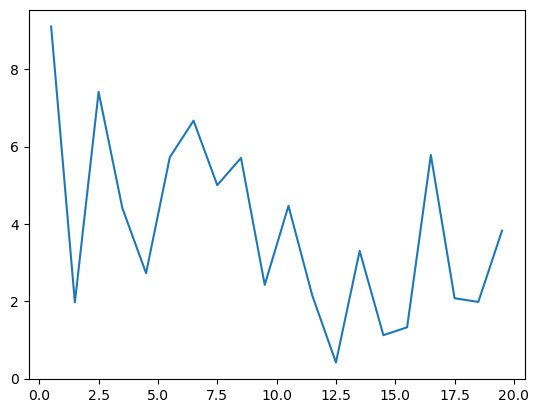

In [46]:
fig, ax = plt.subplots()
ax.plot(x_positions, lactose_conc)

In [44]:
len(results)

200